In [1]:
import gdown
# Use the file ID from the shareable link
file_id = "1GtoXWqjKpwG1UJp5x6kVYBoDlL4QW6Ti"
url = f"https://drive.google.com/uc?id={file_id}"
output = "data.zip"

gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1GtoXWqjKpwG1UJp5x6kVYBoDlL4QW6Ti
From (redirected): https://drive.google.com/uc?id=1GtoXWqjKpwG1UJp5x6kVYBoDlL4QW6Ti&confirm=t&uuid=9d1037e6-f6ca-4325-bd6c-9ce43a5ef86a
To: /content/data.zip
100%|██████████| 110M/110M [00:01<00:00, 61.5MB/s]


'data.zip'

In [2]:
!unzip -q /content/data.zip -d /content/data

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Rescaling
from tensorflow.keras.metrics import Precision, Recall
import numpy as np
import os
import cv2 # OpenCV is used for image loading and resizing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [4]:
# 1. SETUP: Define dataset paths
# --------------------------------------------------
train_REAL = "/content/data/train/REAL"
train_FAKE = "/content/data/train/FAKE"
test_REAL = "/content/data/test/REAL"
test_FAKE = "/content/data/test/FAKE"

tf.random.set_seed(1)
np.random.seed(1)

In [5]:
# 2. DATA LOADING AND PREPARATION
# --------------------------------------------------
def load_images_from_folder(folder, label):
    """
    Loads all images from a given folder, resizes them to 32x32,
    and assigns a specified label.
    """
    images = []
    labels = []
    if not os.path.isdir(folder):
        print(f"Warning: Directory not found at {folder}")
        return np.array([]), np.array([])
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)

        if img is not None:
            img = cv2.resize(img, (32, 32))
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

print("Loading training data...")
train_real_images, train_real_labels = load_images_from_folder(train_REAL, 1)
train_fake_images, train_fake_labels = load_images_from_folder(train_FAKE, 0)

print("Loading testing data...")
test_real_images, test_real_labels = load_images_from_folder(test_REAL, 1)
test_fake_images, test_fake_labels = load_images_from_folder(test_FAKE, 0)

X_train = np.concatenate((train_real_images, train_fake_images), axis=0)
y_train = np.concatenate((train_real_labels, train_fake_labels), axis=0)
X_test = np.concatenate((test_real_images, test_fake_images), axis=0)
y_test = np.concatenate((test_real_labels, test_fake_labels), axis=0)

train_indices = np.arange(X_train.shape[0])
np.random.shuffle(train_indices)
X_train = X_train[train_indices]
y_train = y_train[train_indices]

test_indices = np.arange(X_test.shape[0])
np.random.shuffle(test_indices)
X_test = X_test[test_indices]
y_test = y_test[test_indices]

print(f"\nTraining data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Loading training data...
Loading testing data...

Training data shape: (100000, 32, 32, 3)
Testing data shape: (20000, 32, 32, 3)


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt


In [7]:
# 4. LOGISTIC REGRESSION MODEL
# ----------------------------

# Flatten images: (N, 32, 32, 3) -> (N, 3072)
X_train_lr = X_train.reshape(X_train.shape[0], -1) / 255.0
X_test_lr  = X_test.reshape(X_test.shape[0], -1) / 255.0

print("Train shape for LR:", X_train_lr.shape)
print("Test shape for LR:", X_test_lr.shape)



Train shape for LR: (100000, 3072)
Test shape for LR: (20000, 3072)


In [8]:
# Create and train Logistic Regression model
logreg = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='lbfgs',
    max_iter=2000,
    n_jobs=-1,
    random_state=1
)

logreg.fit(X_train_lr, y_train)


# Predictions
y_pred_lr = logreg.predict(X_test_lr)
y_proba_lr = logreg.predict_proba(X_test_lr)[:, 1]


Logistic Regression - Test Accuracy: 0.6872

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

        REAL       0.69      0.69      0.69     10000
        FAKE       0.69      0.68      0.69     10000

    accuracy                           0.69     20000
   macro avg       0.69      0.69      0.69     20000
weighted avg       0.69      0.69      0.69     20000



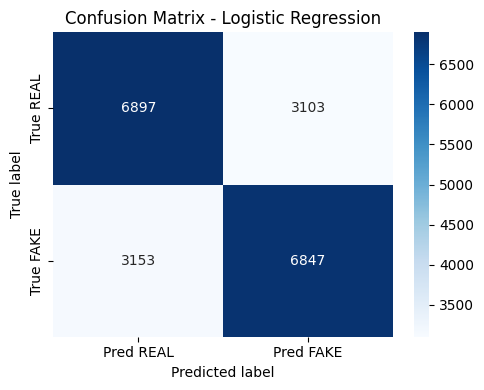

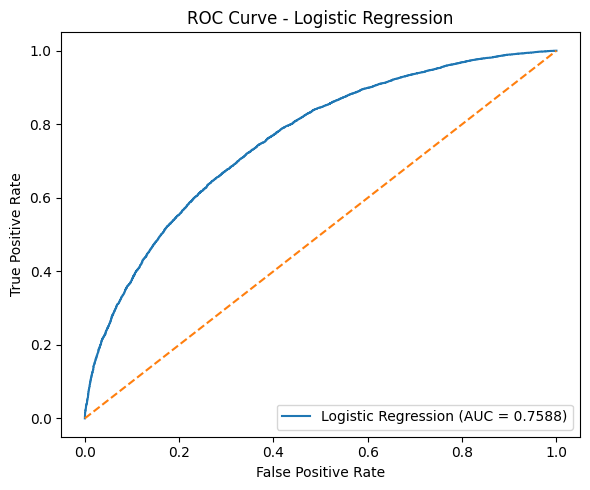

In [9]:
# Accuracy
lr_acc = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression - Test Accuracy: {lr_acc:.4f}")

# Classification report
print("\nClassification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_lr, target_names=["REAL", "FAKE"]))

# Confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred REAL", "Pred FAKE"],
            yticklabels=["True REAL", "True FAKE"])
plt.title("Confusion Matrix - Logistic Regression")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

# ROC curve & AUC
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(6, 5))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_auc_lr:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


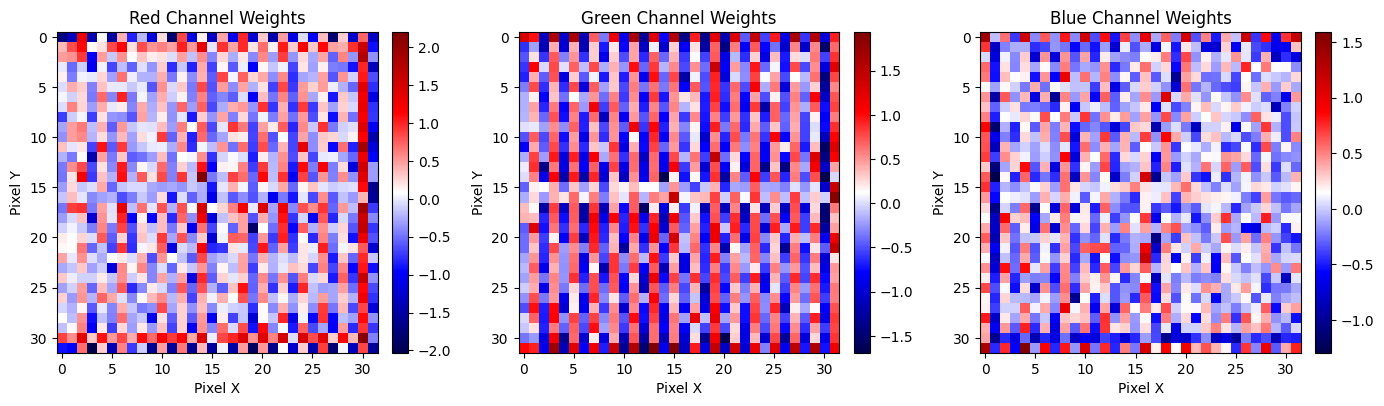

In [14]:
import numpy as np
import matplotlib.pyplot as plt

w = logreg.coef_[0]                  # shape (3072,)
w_img = w.reshape(32, 32, 3)         # reshape into RGB

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

titles = ['Red Channel Weights', 'Green Channel Weights', 'Blue Channel Weights']

for i in range(3):
    im = axes[i].imshow(w_img[:, :, i], cmap='seismic')
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("Pixel X")
    axes[i].set_ylabel("Pixel Y")
    plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()